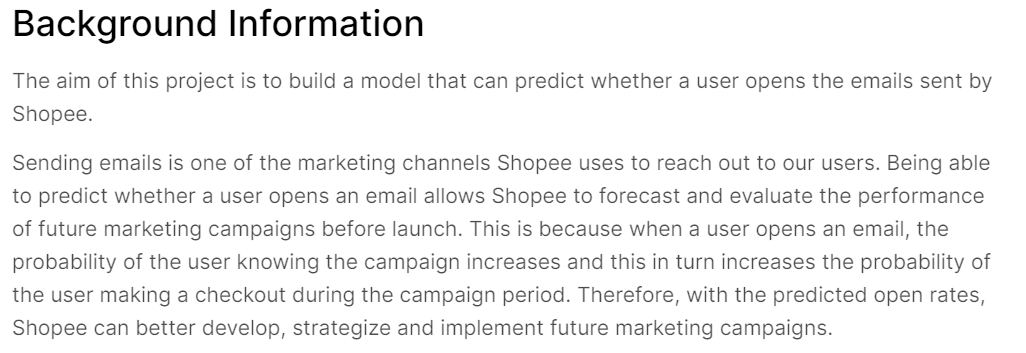

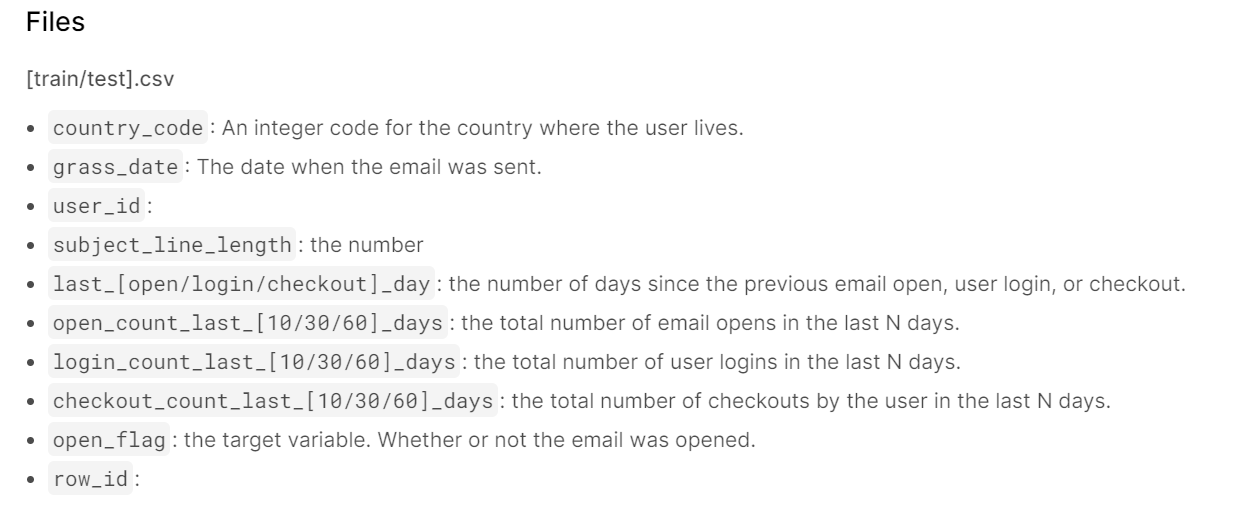

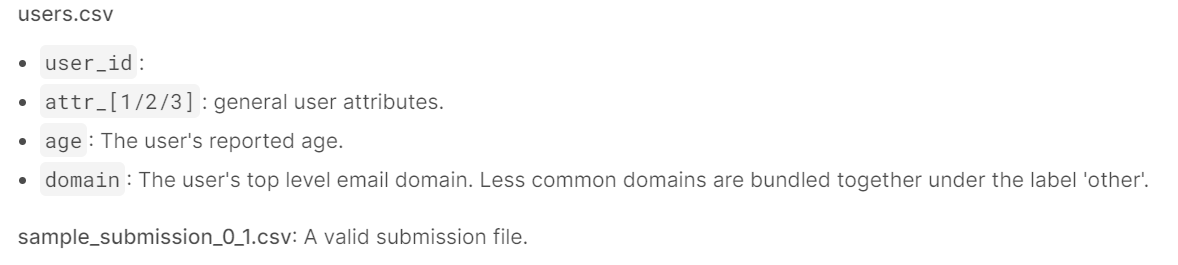

In [329]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73539 entries, 0 to 73538
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country_code                 73539 non-null  int64 
 1   grass_date                   73539 non-null  object
 2   user_id                      73539 non-null  int64 
 3   subject_line_length          73539 non-null  int64 
 4   last_open_day                73539 non-null  object
 5   last_login_day               73539 non-null  object
 6   last_checkout_day            73539 non-null  object
 7   open_count_last_10_days      73539 non-null  int64 
 8   open_count_last_30_days      73539 non-null  int64 
 9   open_count_last_60_days      73539 non-null  int64 
 10  login_count_last_10_days     73539 non-null  int64 
 11  login_count_last_30_days     73539 non-null  int64 
 12  login_count_last_60_days     73539 non-null  int64 
 13  checkout_count_last_10_days  73

In [3]:
users_info = pd.read_csv('users.csv')
users_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127886 entries, 0 to 127885
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  127886 non-null  int64  
 1   attr_1   78987 non-null   float64
 2   attr_2   127439 non-null  float64
 3   attr_3   127886 non-null  float64
 4   age      78987 non-null   float64
 5   domain   127886 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 5.9+ MB


In [4]:
# no null values for train.csv but we see many for user.csv
print(data.isnull().sum())
print()
print(users_info.isnull().sum())

country_code                   0
grass_date                     0
user_id                        0
subject_line_length            0
last_open_day                  0
last_login_day                 0
last_checkout_day              0
open_count_last_10_days        0
open_count_last_30_days        0
open_count_last_60_days        0
login_count_last_10_days       0
login_count_last_30_days       0
login_count_last_60_days       0
checkout_count_last_10_days    0
checkout_count_last_30_days    0
checkout_count_last_60_days    0
open_flag                      0
row_id                         0
dtype: int64

user_id        0
attr_1     48899
attr_2       447
attr_3         0
age        48899
domain         0
dtype: int64


In [5]:
# we will need to convert this into something more representative: which day of the week
data.grass_date.value_counts()

2019-09-02 00:00:00+08:00    3915
2019-08-08 00:00:00+08:00    3127
2019-09-01 00:00:00+08:00    2965
2019-07-30 00:00:00+08:00    2559
2019-07-23 00:00:00+08:00    2469
2019-08-05 00:00:00+08:00    2466
2019-07-16 00:00:00+08:00    2390
2019-08-06 00:00:00+08:00    2344
2019-08-16 00:00:00+08:00    2173
2019-08-19 00:00:00+08:00    2129
2019-07-25 00:00:00+08:00    2023
2019-08-14 00:00:00+08:00    1998
2019-07-29 00:00:00+08:00    1967
2019-08-22 00:00:00+08:00    1695
2019-08-17 00:00:00+08:00    1689
2019-07-22 00:00:00+08:00    1680
2019-07-28 00:00:00+08:00    1602
2019-07-19 00:00:00+08:00    1537
2019-08-28 00:00:00+08:00    1503
2019-08-23 00:00:00+08:00    1483
2019-08-27 00:00:00+08:00    1466
2019-08-30 00:00:00+08:00    1450
2019-07-26 00:00:00+08:00    1422
2019-07-17 00:00:00+08:00    1403
2019-08-20 00:00:00+08:00    1369
2019-08-09 00:00:00+08:00    1358
2019-08-26 00:00:00+08:00    1341
2019-08-15 00:00:00+08:00    1301
2019-08-03 00:00:00+08:00    1280
2019-08-29 00:

In [6]:
# we will need to convert the strings into integers
print(data.last_open_day.value_counts().sort_index(ascending=False))
print()
print(data.last_login_day.value_counts().sort_index(ascending=False))
print()
print(data.last_checkout_day.value_counts().sort_index(ascending=False))

Never open    7518
99              22
98              37
97              31
96              30
              ... 
102             37
101             37
100             39
10            1574
1             5051
Name: last_open_day, Length: 549, dtype: int64

Never login      279
99                69
987                1
98                44
976                1
               ...  
1001               1
100               65
10              1845
1              10852
0                817
Name: last_login_day, Length: 893, dtype: int64

Never checkout    16905
998                   1
996                   1
994                   3
990                   1
                  ...  
1003                  1
1000                  1
100                  82
10                 1166
1                  3184
Name: last_checkout_day, Length: 947, dtype: int64


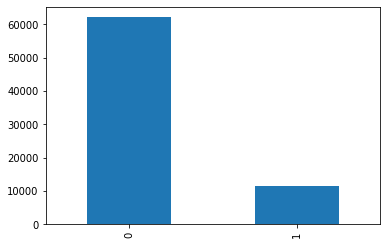

In [8]:
# class size - not balanced, we will need to use MCC for measurement instead of simple accuracy
data.open_flag.value_counts().plot(kind='bar');

In [9]:
users_info.age.isnull().sum()

48899

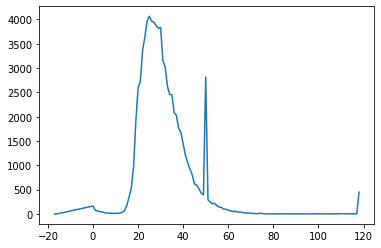

In [10]:
users_info.age.value_counts().sort_index().plot(); # maybe we shall not use this first

### Data Pre-processing

In [402]:
def preprocess_data(raw_data):
    """
    This function cleans the data from train.csv 
    """
    processed_data = raw_data.copy()
    
    processed_data['last_open_day'] = processed_data['last_open_day'].apply(lambda x: -1 if x == "Never open" else int(x))
    processed_data['last_login_day'] = processed_data['last_login_day'].apply(lambda x: -1 if x == "Never login" else int(x))
    processed_data['last_checkout_day'] = processed_data['last_checkout_day'].apply(lambda x: -1 if x == "Never checkout" else int(x))
    
    # transform date of email sent into day of the week (0-6)
    processed_data['grass_date'] = processed_data['grass_date'].apply(lambda x: pd.to_datetime(x[:10]))
    processed_data['grass_date'] = processed_data['grass_date'].dt.dayofweek
    
    return processed_data

def preprocess_users(raw_users_data):
    """
    This function cleans the data from users.csv
    """
    processed_users = raw_users_data.copy()
    
    # handle null values in user.csv
    processed_users['attr_1'] = processed_users['attr_1'].apply(lambda x: -1 if np.isnan(x) else int(x))
    processed_users['attr_2'] = processed_users['attr_2'].apply(lambda x: -1 if np.isnan(x) else int(x))
    processed_users['attr_3'] = processed_users['attr_3'].apply(lambda x: -1 if np.isnan(x) else int(x))
    processed_users['age'] = processed_users['age'].apply(lambda x: -1 if np.isnan(x) else int(x))
    
    # make one-hot encoding for email domains
    processed_users = pd.get_dummies(processed_users, columns=['domain']) 
    
    return processed_users

In [403]:
processed_data, processed_user = preprocess_data(data), preprocess_users(users_info)

In [404]:
print(processed_data.info())
print()
print(processed_user.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73539 entries, 0 to 73538
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   country_code                 73539 non-null  int64
 1   grass_date                   73539 non-null  int64
 2   user_id                      73539 non-null  int64
 3   subject_line_length          73539 non-null  int64
 4   last_open_day                73539 non-null  int64
 5   last_login_day               73539 non-null  int64
 6   last_checkout_day            73539 non-null  int64
 7   open_count_last_10_days      73539 non-null  int64
 8   open_count_last_30_days      73539 non-null  int64
 9   open_count_last_60_days      73539 non-null  int64
 10  login_count_last_10_days     73539 non-null  int64
 11  login_count_last_30_days     73539 non-null  int64
 12  login_count_last_60_days     73539 non-null  int64
 13  checkout_count_last_10_days  73539 non-null  i

In [405]:
merged_data = pd.merge(left=processed_data, right=processed_user, how='left', left_on='user_id', right_on='user_id')
merged_data
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73539 entries, 0 to 73538
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   country_code                 73539 non-null  int64
 1   grass_date                   73539 non-null  int64
 2   user_id                      73539 non-null  int64
 3   subject_line_length          73539 non-null  int64
 4   last_open_day                73539 non-null  int64
 5   last_login_day               73539 non-null  int64
 6   last_checkout_day            73539 non-null  int64
 7   open_count_last_10_days      73539 non-null  int64
 8   open_count_last_30_days      73539 non-null  int64
 9   open_count_last_60_days      73539 non-null  int64
 10  login_count_last_10_days     73539 non-null  int64
 11  login_count_last_30_days     73539 non-null  int64
 12  login_count_last_60_days     73539 non-null  int64
 13  checkout_count_last_10_days  73539 non-null  i

**Due to high dimensionality, it is also worth looking into feature correlations and covariances for possible PCA**

In [406]:
merged_data.drop(columns=['row_id'], inplace=True)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73539 entries, 0 to 73538
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   country_code                 73539 non-null  int64
 1   grass_date                   73539 non-null  int64
 2   user_id                      73539 non-null  int64
 3   subject_line_length          73539 non-null  int64
 4   last_open_day                73539 non-null  int64
 5   last_login_day               73539 non-null  int64
 6   last_checkout_day            73539 non-null  int64
 7   open_count_last_10_days      73539 non-null  int64
 8   open_count_last_30_days      73539 non-null  int64
 9   open_count_last_60_days      73539 non-null  int64
 10  login_count_last_10_days     73539 non-null  int64
 11  login_count_last_30_days     73539 non-null  int64
 12  login_count_last_60_days     73539 non-null  int64
 13  checkout_count_last_10_days  73539 non-null  i

In [407]:
merged_data_corr = merged_data.corr()
merged_data_corr['open_flag'] # corr coeff for each feature wrt to open_flag

country_code                   0.158945
grass_date                    -0.003278
user_id                       -0.008082
subject_line_length           -0.057357
last_open_day                 -0.150806
last_login_day                 0.001881
last_checkout_day              0.000592
open_count_last_10_days        0.515307
open_count_last_30_days        0.507853
open_count_last_60_days        0.477766
login_count_last_10_days       0.014023
login_count_last_30_days       0.010134
login_count_last_60_days       0.008633
checkout_count_last_10_days    0.015573
checkout_count_last_30_days    0.013419
checkout_count_last_60_days    0.010231
open_flag                      1.000000
attr_1                        -0.000336
attr_2                        -0.016514
attr_3                        -0.014235
age                            0.041007
domain_@163.com                0.003110
domain_@gmail.com             -0.096021
domain_@hotmail.com            0.083738
domain_@icloud.com             0.031938


**It seems like our target open_flag does not really seem to depend on that many features in our data**

In [408]:
# 'RdBu_r', BrBG', 'coolwarm' are good diverging colormaps
merged_data_corr.style.background_gradient(cmap='RdBu_r').set_precision(2)

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,attr_1,attr_2,attr_3,age,domain_@163.com,domain_@gmail.com,domain_@hotmail.com,domain_@icloud.com,domain_@live.com,domain_@outlook.com,domain_@qq.com,domain_@rocketmail.com,domain_@yahoo.com,domain_@ymail.com,domain_other
country_code,1.00,-0.00,-0.05,-0.23,-0.06,0.04,0.00,0.07,0.07,0.06,-0.09,-0.10,-0.10,-0.01,-0.02,-0.03,0.16,-0.09,-0.06,-0.06,-0.03,-0.00,-0.21,0.18,0.03,0.03,0.03,-0.00,-0.01,0.10,-0.02,0.07
grass_date,-0.00,1.00,0.02,-0.06,-0.02,-0.00,-0.00,0.04,0.04,0.03,0.02,0.01,0.01,0.01,0.01,0.01,-0.00,0.00,0.03,-0.00,-0.00,-0.01,0.00,0.02,-0.00,0.00,0.00,-0.00,0.00,-0.01,0.01,-0.00
user_id,-0.05,0.02,1.00,0.09,-0.14,0.02,-0.15,-0.00,-0.01,-0.02,-0.22,-0.24,-0.27,-0.12,-0.14,-0.16,-0.01,-0.31,0.06,-0.27,-0.28,0.03,0.04,-0.04,0.01,-0.01,0.02,0.09,-0.01,-0.06,-0.03,0.02
subject_line_length,-0.23,-0.06,0.09,1.00,0.03,-0.01,0.02,-0.03,-0.05,-0.05,-0.01,-0.01,-0.01,0.01,0.01,0.01,-0.06,0.01,-0.03,-0.00,-0.02,-0.00,0.06,-0.06,-0.01,-0.01,-0.00,-0.01,0.01,-0.02,0.01,-0.02
last_open_day,-0.06,-0.02,-0.14,0.03,1.00,0.02,0.06,-0.24,-0.26,-0.25,-0.00,-0.00,0.01,-0.00,-0.00,0.00,-0.15,0.03,0.03,0.03,0.00,-0.00,-0.02,0.00,-0.00,-0.01,-0.01,-0.02,0.00,0.04,0.01,-0.02
last_login_day,0.04,-0.00,0.02,-0.01,0.02,1.00,0.08,-0.01,-0.01,-0.01,-0.09,-0.09,-0.09,-0.05,-0.05,-0.05,0.00,-0.10,0.01,-0.09,-0.09,-0.00,-0.00,0.00,0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,0.00
last_checkout_day,0.00,-0.00,-0.15,0.02,0.06,0.08,1.00,-0.01,-0.00,0.00,-0.19,-0.20,-0.19,-0.13,-0.14,-0.14,0.00,0.04,0.00,0.01,0.04,-0.02,0.01,-0.00,0.00,0.01,-0.00,-0.03,-0.00,-0.01,0.00,-0.00
open_count_last_10_days,0.07,0.04,-0.00,-0.03,-0.24,-0.01,-0.01,1.00,0.88,0.79,0.04,0.04,0.04,0.03,0.03,0.03,0.52,0.02,0.03,-0.00,0.05,0.02,-0.08,0.05,0.04,0.03,0.03,0.03,0.01,0.01,0.00,0.05
open_count_last_30_days,0.07,0.04,-0.01,-0.05,-0.26,-0.01,-0.00,0.88,1.00,0.94,0.03,0.04,0.04,0.02,0.03,0.03,0.51,0.02,0.04,-0.00,0.05,0.02,-0.07,0.05,0.04,0.02,0.03,0.04,0.01,-0.00,-0.00,0.05
open_count_last_60_days,0.06,0.03,-0.02,-0.05,-0.25,-0.01,0.00,0.79,0.94,1.00,0.03,0.03,0.04,0.02,0.02,0.03,0.48,0.02,0.04,0.00,0.06,0.03,-0.06,0.05,0.04,0.02,0.02,0.04,0.01,-0.01,-0.00,0.05


In [409]:
def email_clfr(nb_features, nb_hidden_layers, nb_hidden_units, learning_rate):
    """
    This function creates the classification model based on the given hyperparameters
    """
    if nb_hidden_layers != len(nb_hidden_units):
        print("List size of hidden_units must equal to hidden_layers")
        return None
    
    else:
        model = Sequential()
        for layer in range(nb_hidden_layers):
            if layer == 0:
                model.add(Dense(units=nb_hidden_units[layer], input_shape=(nb_features,), activation='relu'))
            else:
                model.add(Dense(units=nb_hidden_units[layer], activation='relu'))
                
        model.add(Dense(units=1, activation='sigmoid'))
        
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics = ['accuracy', matthews_correlation])
        
        print(model.summary())
        return model

In [410]:
# custom metric for evaluation
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [411]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73539 entries, 0 to 73538
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   country_code                 73539 non-null  int64
 1   grass_date                   73539 non-null  int64
 2   user_id                      73539 non-null  int64
 3   subject_line_length          73539 non-null  int64
 4   last_open_day                73539 non-null  int64
 5   last_login_day               73539 non-null  int64
 6   last_checkout_day            73539 non-null  int64
 7   open_count_last_10_days      73539 non-null  int64
 8   open_count_last_30_days      73539 non-null  int64
 9   open_count_last_60_days      73539 non-null  int64
 10  login_count_last_10_days     73539 non-null  int64
 11  login_count_last_30_days     73539 non-null  int64
 12  login_count_last_60_days     73539 non-null  int64
 13  checkout_count_last_10_days  73539 non-null  i

In [462]:
y = merged_data.iloc[:,16:17]
X = merged_data.drop(columns=['open_flag'],axis=0)

In [463]:
X = X[['country_code',
       'last_open_day', 
       'open_count_last_10_days', 
       'open_count_last_30_days', 
       'open_count_last_60_days',
       'attr_1', 
       'attr_2', 
       'attr_3',
       'domain_@163.com', 
       'domain_@gmail.com', 
       'domain_@hotmail.com',
       'domain_@icloud.com', 
       'domain_@live.com', 
       'domain_@outlook.com',
       'domain_@qq.com', 
       'domain_@rocketmail.com', 
       'domain_@yahoo.com',
       'domain_@ymail.com', 
       'domain_other']]
X.columns
print(len(X.columns))

19


In [464]:
scaler = MinMaxScaler(feature_range = (0,1))

In [465]:
X_scaled = scaler.fit_transform(X)

In [466]:
print(X_scaled.shape)

X_scaled

(73539, 19)


array([[0.5       , 0.02472188, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.01236094, 0.06451613, ..., 0.        , 0.        ,
        0.        ],
       [0.83333333, 0.01854141, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.16666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.00741656, 0.06451613, ..., 0.        , 0.        ,
        0.        ],
       [0.83333333, 0.00247219, 0.06451613, ..., 0.        , 0.        ,
        0.        ]])

In [467]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

In [468]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print()
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (51477, 19)
y_train shape: (51477, 1)

X_test shape: (22062, 19)
y_test shape: (22062, 1)


In [438]:
# os = SMOTE(random_state=0)
# os_X_train, os_y_train = os.fit_sample(X_train, y_train)

In [439]:
# print("Sample Size: " + str(len(os_X_train)))
# print("Label 0: " + str(np.sum(os_y_train == 0)))
# print("Label 1: " + str(np.sum(os_y_train == 1)))

### Model Training

In [474]:
# Early stopping
es = EarlyStopping(monitor='matthews_correlation', mode='max', verbose=1, patience=2000)
mc = ModelCheckpoint('best_model.h5', monitor='val_matthews_correlation', mode='max', verbose=1, save_best_only=True)

In [488]:
classifier = email_clfr(nb_features=19, nb_hidden_layers=5, nb_hidden_units=[10,10,10,10,10], learning_rate=0.01)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 10)                200       
_________________________________________________________________
dense_181 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_182 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_183 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_184 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_185 (Dense)            (None, 1)                 11        
Total params: 651
Trainable params: 651
Non-trainable params: 0
_______________________________________________________

In [ ]:
history = classifier.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 20000, batch_size = 1024, callbacks = [es,mc])

In [3]:
#load the saved model
saved_model = load_model('best_model.h5', custom_objects={'matthews_correlation': matthews_correlation})

# evaluate the model
_, train_acc, train_mcc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc, test_mcc = saved_model.evaluate(X_test, y_test, verbose=0)

print("Train Acc: " + str(train_acc))
print("Train MCC: " + str(train_mcc))
print()
print("Test Acc: " + str(test_acc))
print("Test MCC: " + str(test_mcc))

In [491]:
test_data = pd.read_csv('test.csv')
processed_test = preprocess_data(test_data)

merged_test_data = pd.merge(left=processed_test, right=processed_user, how='left', left_on='user_id', right_on='user_id')
merged_test_data

merged_test_data.drop(columns=['row_id','age'], inplace=True)

In [492]:
merged_test_data = merged_test_data[['country_code', 
                                     'last_open_day', 
                                     'open_count_last_10_days', 
                                     'open_count_last_30_days',
                                     'open_count_last_60_days',
                                     'attr_1', 
                                     'attr_2', 
                                     'attr_3',
                                     'domain_@163.com', 
                                     'domain_@gmail.com', 
                                     'domain_@hotmail.com',
                                     'domain_@icloud.com', 
                                     'domain_@live.com', 
                                     'domain_@outlook.com',
                                     'domain_@qq.com', 
                                     'domain_@rocketmail.com', 
                                     'domain_@yahoo.com',
                                     'domain_@ymail.com', 
                                     'domain_other']]
merged_test_data

,country_code,last_open_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,attr_1,attr_2,attr_3,domain_@163.com,domain_@gmail.com,domain_@hotmail.com,domain_@icloud.com,domain_@live.com,domain_@outlook.com,domain_@qq.com,domain_@rocketmail.com,domain_@yahoo.com,domain_@ymail.com,domain_other
0,6,27,2,3,4,-1,1,0,0,1,0,0,0,0,0,0,0,0,0
1,6,7,1,1,1,-1,1,0,0,1,0,0,0,0,0,0,0,0,0
2,5,34,0,0,0,1,1,2,0,1,0,0,0,0,0,0,0,0,0
3,1,63,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0
4,5,6,0,0,0,-1,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,-1,0,0,0,-1,1,0,0,1,0,0,0,0,0,0,0,0,0
55966,6,59,0,0,1,-1,1,0,0,1,0,0,0,0,0,0,0,0,0
55967,6,-1,0,0,0,-1,1,0,0,0,1,0,0,0,0,0,0,0,0
55968,6,5,2,5,14,-1,1,0,0,1,0,0,0,0,0,0,0,0,0


In [493]:
scaled_test = scaler.fit_transform(merged_test_data)

### Prediction

In [494]:
open_flags = saved_model.predict(scaled_test)

In [495]:
open_flags[:,0].shape

(55970,)

In [496]:
open_flags = (open_flags[:,0] > .5).astype(int)

In [497]:
open_flags

array([0, 0, 0, ..., 0, 0, 1])

### Submission

In [498]:
submission = pd.DataFrame({"row_id": test_data['row_id'],
                           "open_flag": open_flags})

submission.to_csv("submission_15.csv", index=False)


### Model Saving

In [499]:
# save weights only
classifier.save_weights('classifier_15.h5')

# save architecture only
model_architecture = classifier.to_json()
with open('classifier_15.json','w') as json_file:
    json_file.write(model_architecture)

### Model Loading

In [ ]:
# # Load model architecture and weights
# from keras.models import model_from_json
# with open('Final_Model_architecture.json','r') as json_file:
#     architecture = json_file.read()
    
# model = model_from_json(architecture)
# model.load_weights('Final_Model_weights.h5')